In [1]:
%matplotlib inline
from pylab import *

import shutil
import sys
import os.path
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from scipy.optimize import minimize
import itertools
import pyomo.environ as env
import ast
from pyomo.environ import *
#solver = env.SolverFactory("ipopt")

import networkx as nx
from networkx.drawing.nx_agraph import write_dot, graphviz_layout

In [2]:
import watertap as wt

In [3]:
fw_filename = 'water_input_example.csv'
feedwater_data = wt.importfile.feedwater(fw_filename)
#output_water = wt.run_unit_process(feedwater_data, unit_process = 'microfiltration_a')

In [4]:
def treatment_draw(G):
    pos =graphviz_layout(G, prog='dot')
    return nx.draw(G, pos, with_labels=True, arrows=True)

In [5]:
def create_empty_train():
    return nx.DiGraph()

In [6]:
def add_multiple_unit_processes(G, unit_process_name_list='unit_process', 
                                from_process_lib=False,
                    from_process='None', to_process='None'):
    
    for unit_process_name in unit_process_name_list:
        print('adding unit process to network:', unit_process_name) # turn this to if statement
                
        G.add_edges_from([('source_node', unit_process_name, 
                           {'name': ('%s_source_stream' % unit_process_name),
                           'type': 'source_stream'}), 
                          (unit_process_name, 'end_node', 
                           {'name': ('%s_treated_stream' % unit_process_name),
                           'type': 'recovery_stream'})])
        
        G.add_edge(unit_process_name, ('%s_waste_node' % unit_process_name), 
                   name =('%s_waste_stream' % unit_process_name)) #TODO make name same
        
        G.edges[unit_process_name, ('%s_waste_node' % unit_process_name)]['type'] = 'waste_stream'
        
    for node in G.nodes():
        G.nodes[node]['name']=node
        G.nodes[node]['type']='storage'
        if node in unit_process_name_list: G.nodes[node]['type']='treatment_process'
        
    if from_process_lib is True:
        G = wt.set_up_unit_process(G)
    
    #add option to read in multiple from and to
    #add option to import for existing list if from_process_lib is true
    
    return G

In [7]:
def get_link_list(G):
    link_list = []
    for edge in G.edges():
        link_list.append(G.edges[edge]['name'])
    return link_list

In [8]:
def get_link_df(G):
    df = pd.DataFrame.from_dict(G.edges(data=True))
    link_name = []; link_type = [];

    for row in range(0, len(df)):
        link_name.append(df[2][row]['name'])
        link_type.append(df[2][row]['type'])

    df['name'] = link_name
    df['type'] = link_type
    df = df.set_index(df.name)
    
    return df

In [9]:
def get_source_nodes(G): # need to diffrentiate source nodes in some way if there are multiple source nodes.
    source_node_list = []
    for edge in G.edges():
        if G.nodes[edge[0]]['type'] == 'storage':
            if edge[0] not in source_node_list: source_node_list.append(edge[0])
        
    return source_node_list

In [10]:
def get_outflow_links(G):
    outflow_links = []
    for up in unit_process_name_list:
        for out_link in G.out_edges(up):
            outflow_links.append(G.edges[out_link]['name'])
    return outflow_links

In [11]:
def get_recovered_water_nodes(G):
    recovered_water_node_list = []
    for edge in G.edges():
        if ((G.nodes[edge[1]]['type'] == 'storage') & (G.nodes[edge[1]]['name'] == 'end_node')):
            if edge[1] not in recovered_water_node_list: recovered_water_node_list.append(edge[1])
    return recovered_water_node_list

In [12]:
#### MODEL FUNCTIONS ####

In [40]:
# LINKS COMING OUT OF SOURCE NODE MUST EQUAL FEEDWATER TOTAL! 
def inflow_constraint(m, source_node):
    inflow_link_list = [];

    for inflow_link in G.out_edges(source_node): # TO DO MAKE FUNCTION
        inflow_link_list.append(G.edges[inflow_link]['name'])
    
    flow_in = feedwater_data.loc['Flow'].feedwater
        
    return sum(m.FlowInLinkSegments[e] for e in inflow_link_list) == flow_in

In [41]:
def up_mass_balance_constraint(m, up):
    
    flow_in = 0
    for i in G.in_edges(up):
        flow_in = flow_in + m.FlowInLinkSegments[G.edges[i]['name']]

    flow_out = 0
    for i in G.out_edges(up):
        flow_out = flow_out + m.FlowInLinkSegments[G.edges[i]['name']]
    
    return (-0.0000001, flow_in - flow_out, 0.0000001)


In [42]:
def calculate_out_flows(m, link):
    if link in get_outflow_links(G):
    
        # equation for sum of inflows
        inflow_links = []
        up = get_link_df(G).loc[link][0] #change column names for df so easier to follow
        for inflow_link in G.in_edges(up):
            inflow_links.append(G.edges[inflow_link]['name'])   

        sum_of_up_inflow = sum(m.FlowInLinkSegments[inflow_link] for inflow_link in inflow_links)

        # equation for recovered water
        if get_link_df(G).loc[link][2]['type'] == 'recovery_stream':
            return m.FlowInLinkSegments[link] == sum_of_up_inflow * G.nodes[up]['recovery_factor']

        if get_link_df(G).loc[link][2]['type'] == 'waste_stream':
            return m.FlowInLinkSegments[link] == sum_of_up_inflow * (1 - G.nodes[up]['recovery_factor'])    
    else:
        return m.FlowInLinkSegments[link] >= 0

In [43]:
def calculate_recovered_water(m, end_node):

    recovered_flow = 0; # CAN DO SUM INSTREAD with list of nodes/links? outflow_link_list = []; 

    for up_outflow_link in G.in_edges(end_node): # TO DO MAKE FUNCTION
        #outflow_link_list.append(G.edges[outflow_link]['name'])
    
        recovered_flow = recovered_flow + m.FlowInLinkSegments[G.edges[up_outflow_link]['name']]
    
    return model.RecoveredFlow[end_node] == recovered_flow

adding unit process to network: microfiltration_a
adding unit process to network: ultrafiltration_a
adding unit process to network: uv_a
adding unit process attributes: microfiltration_a
adding unit process attributes: ultrafiltration_a
adding unit process attributes: uv_a


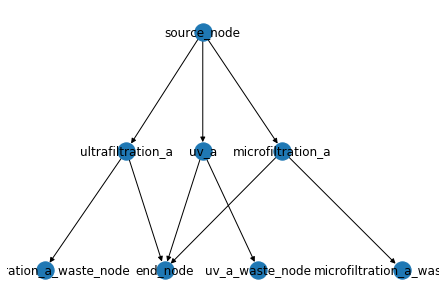

In [17]:
# create empty train to be populated with unit processes etc.
G = create_empty_train()

# add unit processes to treatment train
unit_process_name_list = wt.unit_process_library_list #['microfiltration_a']
#unit_process_name_list = [wt.unit_process_library_list[0], wt.unit_process_library_list[1]]

G = add_multiple_unit_processes(G, unit_process_name_list=unit_process_name_list, 
                     from_process='None', to_process='None', from_process_lib=True)

treatment_draw(G)

In [27]:
model = env.ConcreteModel()
model.LinkSet = env.Set(initialize=get_link_list(G)) # all links in network
model.UnitProcesses = env.Set(initialize=unit_process_name_list) # all unit processes
model.SourceNodes = env.Set(initialize=get_source_nodes(G)) # all source nodes
model.RecoveredWaterNodes = env.Set(initialize=get_recovered_water_nodes(G)) # all recovered water nodes

model.FlowInLinkSegments = env.Var(model.LinkSet, bounds=(0,None))
model.RecoveredFlow = env.Var(model.RecoveredWaterNodes, bounds=(0,None))

In [28]:
# Equations for mass balance
model.UPMassBalanceConstraint = env.Constraint(model.UnitProcesses, rule=up_mass_balance_constraint)

In [29]:
# Makes sure inlet streams add up to feedwater volume
model.CheckUnitInletFlows = env.Constraint(model.SourceNodes, rule=inflow_constraint)

/Users/amiara/miniconda3/envs/water-hubv2/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  # Remove the CWD from sys.path while we load stuff.


In [30]:
# Equations for outlet flows
model.CalculateFlows = env.Constraint(model.LinkSet, rule=calculate_out_flows)

/Users/amiara/miniconda3/envs/water-hubv2/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  # This is added back by InteractiveShellApp.init_path()


recovery_factor 0.95
microfiltration_a_waste_stream
recovery_factor 0.97
ultrafiltration_a_waste_stream
recovery_factor 0.99
uv_a_waste_stream


In [31]:
# Calculate recovered water
model.CalculateRecoveredWater = env.Constraint(model.RecoveredWaterNodes, rule=calculate_recovered_water)

In [36]:
model.objective_function = env.Objective(
    #expr=sum(model.FlowInLinkSegments[x] for x in model.LinkSet), # max flows all links -> simulation
    expr=sum(model.RecoveredFlow[x] for x in model.RecoveredWaterNodes), # can do this for node?
    sense=env.maximize)

/Users/amiara/miniconda3/envs/water-hubv2/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [37]:
solver = env.SolverFactory("ipopt")
solver.solve(model)

{'Problem': [{'Lower bound': -inf, 'Upper bound': inf, 'Number of objectives': 1, 'Number of constraints': 14, 'Number of variables': 10, 'Sense': 'unknown'}], 'Solver': [{'Status': 'ok', 'Message': 'Ipopt 3.12.12\\x3a Optimal Solution Found', 'Termination condition': 'optimal', 'Id': 0, 'Error rc': 0, 'Time': 0.06704998016357422}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

In [38]:
print({x: env.value(model.FlowInLinkSegments[x]) for x in model.LinkSet})

{'microfiltration_a_source_stream': 2.1628923806634478e-07, 'ultrafiltration_a_source_stream': 4.664875348777222e-07, 'uv_a_source_stream': 999.9999993172232, 'microfiltration_a_treated_stream': 2.0547477616302077e-07, 'microfiltration_a_waste_stream': 1.0814461903318933e-08, 'ultrafiltration_a_treated_stream': 4.5249290883144205e-07, 'ultrafiltration_a_waste_stream': 1.3994626046330989e-08, 'uv_a_treated_stream': 989.9999993240509, 'uv_a_waste_stream': 9.99999999317224}


In [39]:
for x in model.LinkSet:
    print(x, ':', env.value(model.FlowInLinkSegments[x]))

microfiltration_a_source_stream : 2.1628923806634478e-07
ultrafiltration_a_source_stream : 4.664875348777222e-07
uv_a_source_stream : 999.9999993172232
microfiltration_a_treated_stream : 2.0547477616302077e-07
microfiltration_a_waste_stream : 1.0814461903318933e-08
ultrafiltration_a_treated_stream : 4.5249290883144205e-07
ultrafiltration_a_waste_stream : 1.3994626046330989e-08
uv_a_treated_stream : 989.9999993240509
uv_a_waste_stream : 9.99999999317224


In [ ]:
def add_unit_process(G, unit_process_name='unit_process', from_process_lib='False'):
    print('adding unit process', unit_process)
    #add option to import for existing list if from_process_lib is true
    return G.add_node(unit_process)

In [ ]:
output_data = wt.run_treatment(FEEDWATER, DESIRED OUTPUT QUALITY?!?!?!, TRAIN OR MODULE- SET OR UNSET)

# do we want to change the unit-level processes - like add more chemicals - to achieve a better outcome?!

In [ ]:
##### MAYBE CODES #####

In [ ]:
def add_unit_process(G, unit_process_name='unit_process', from_process_lib='False',
                    from_process='None', to_process='None'):
    print('adding unit process', unit_process_name)
    
    G.add_edges_from([('source_node', unit_process_name, {'name': 'source_stream'}), 
                      (unit_process_name, 'end_node', {'name': 'treated_stream'})])
    
    #add option to read in multiple from and to
    #add option to import for existing list if from_process_lib is true
    
    return G

In [ ]:
feedwater = dict()
for row in range(0, len(feedwater_data)):
    feedwater[feedwater_data.Variable[row]] = feedwater_data.Value[row]